[  0.27929223   0.43458723   0.67623097   1.05223599   1.63731127
   2.54770624   3.96430855   6.16858491   9.5985061   14.935568
  23.24019896  36.16245781  56.26988639  87.55765801 136.24238413]


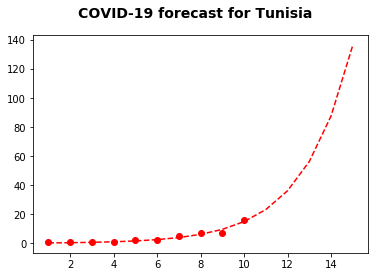

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
from scipy.optimize import curve_fit

data = pd.read_csv("../data/time_series_19-covid-Confirmed.csv")

def clean_data(dataframe, country):
    mydata = dataframe[dataframe['Country/Region'] == country].drop(columns=["Province/State", 
            "Country/Region", "Lat", "Long"]).reset_index(drop=True).T
    mydata.rename(columns={0:"cumulative_count"}, inplace=True)
    mydata["date"] = pd.to_datetime( mydata.index )
    mydata = mydata[mydata["cumulative_count"]!=0]
    mydata["days"] = np.linspace(1, len(mydata), len(mydata))
    mydata.reset_index(drop=True, inplace=True)   
    return mydata 

def SPG(t, r, m, A):
    """ """
    return (  ((r/m)*np.array(t)  ) +A )**m

def expgrowth(t, alpha, beta): 
    """ exponential growth"""
    return alpha*np.exp( np.array(t))**beta

def curve_fitting(dataframe): 
    days = dataframe.days
    cases_count = dataframe.cumulative_count
    parameters, pcov = curve_fit(expgrowth, days, cases_count)
    return parameters, pcov

def plot_exp_forecast(dataframne, popt, forecast_offset=5, color="red"): 
    plot1 = plt.plot(dataframne.days, dataframne.cumulative_count,'o'  ,color =color)
    offset_array = np.arange(list(dataframne.days)[-1]+1, list(dataframne.days)[-1]+forecast_offset+1  )
    offset = np.append(dataframne.days, offset_array )
    plot2 =  plt.plot(offset, expgrowth(offset, *popt),"--",color =color)    
    return plot1, plot2





fig = plt.figure()
fig.suptitle('COVID-19 forecast for Tunisia', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
#ax.text(1, 12, r'Forecast for {0} after the \n first  day of the outbreak', 
#        bbox={'facecolor': 'white',  'pad': 10})
popt, pcov = curve_fitting(Tunisia)
plot_exp_forecast(Tunisia, popt, 5)

plt.savefig("COVID_Tn.svg")




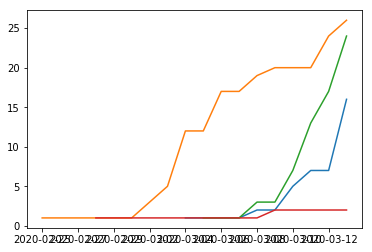

In [2]:
Italy = clean_data(data, "Italy")
Tunisia = clean_data(data, "Tunisia")
Algeria = clean_data(data, "Algeria")
SA = clean_data(data, "South Africa")
Egypt = clean_data(data, "Egypt")
Nigeria = clean_data(data, "Nigeria")
#plt.plot(Italy.date, Italy.cumulative_count )
plt.plot(Tunisia.date, Tunisia.cumulative_count )
plt.plot(Algeria.date, Algeria.cumulative_count )
plt.plot(SA.date, SA.cumulative_count)
#plt.plot(Egypt.date, Egypt.cumulative_count )
plt.plot(Nigeria.date, Nigeria.cumulative_count )



[  0.27929223   0.43458723   0.67623097   1.05223599   1.63731127
   2.54770624   3.96430855   6.16858491   9.5985061   14.935568
  23.24019896  36.16245781  56.26988639  87.55765801 136.24238413]


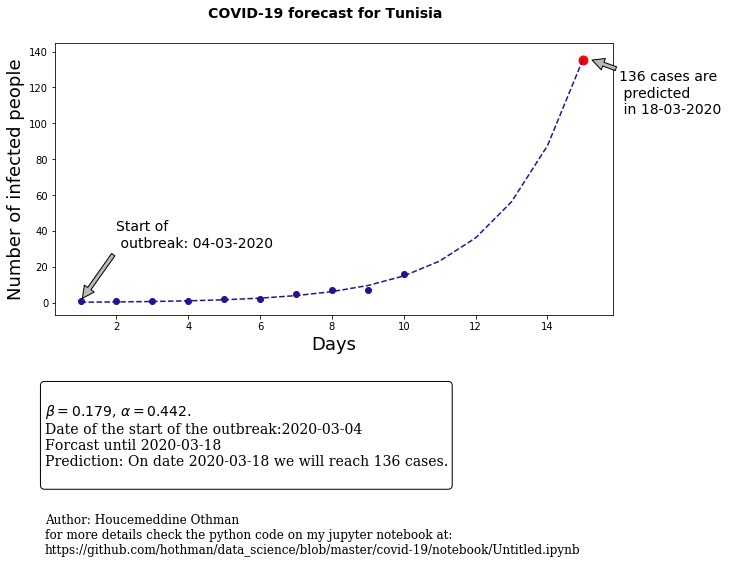

In [339]:
import random 
import matplotlib.colors as col 
import itertools
from datetime import datetime, timedelta

def random_col(alpha=1, keep_alpha=False):
    r = random.random()
    g = random.random()
    b = random.random()
    return col.to_hex((r, g, b, alpha), keep_alpha=keep_alpha)
    
def wrap(countries, dataframe, forecast=5):
    number_of_panels = len(countries)
    fig, axs = plt.subplots(figsize=(10, 5) )    
    for country in countries: 
        idx = countries.index(country)
        clean = clean_data(dataframe, country)
        forecasted_date = list(clean.date)[-1]+timedelta(days=forecast)
        #timedelta(days=forecast)
        popt, pcov = curve_fitting(clean)
        alpha = round(popt[0],3) 
        beta = round(popt[1],3) 
        day_list = list(clean["days"])
        forecast_day = day_list[-1] + forecast
        cases_forecasted_day = expgrowth(t=forecast_day, alpha=alpha, beta=beta) 
        
        fig.suptitle('COVID-19 forecast for {0}'.format(country), fontsize=14, fontweight='bold')
        plt.xlabel("Days", fontsize=18)
        plt.ylabel("Number of infected people", fontsize=18)
        plot1, plot2 = plot_exp_forecast(clean, popt, forecast, color = random_col() )
        # text to insert in the figure
        text= r"""
        $\beta = {3}$, $\alpha = {2}$.
        Date of the start of the outbreak:{0}
        Forcast until {1}
        Prediction: On date {4} we will reach {5} cases.
        """.format(clean.date[0].strftime("%Y-%m-%d"),
                   forecasted_date.strftime("%Y-%m-%d"),
                   beta, alpha, 
                   forecasted_date.strftime("%Y-%m-%d"),
                   int( round(cases_forecasted_day,0)) )
        text2 = """Author: Houcemeddine Othman
                   for more details check the python code on my jupyter notebook at:
                   https://github.com/hothman/data_science/blob/master/covid-19/notebook/Untitled.ipynb"""
                

        plt.scatter(forecast_day, cases_forecasted_day, color="red", s=80 )
        plt.text(0, -100, text, ha='left', wrap=True, fontsize=14, family='serif', 
                bbox=dict(boxstyle="round", fc="none") )
        plt.text(0, -140, text2 , ha='left', wrap=True, fontsize=12, family='serif', 
                 )
        
        start_day = list(clean.days)[0]
        cases_on_start_day = list(clean.cumulative_count)[0]
        x_annot_box1 = start_day+1
        y_annot_box1 = cases_on_start_day+30
        axs.annotate('Start of \n outbreak: {0} '.format(clean.date[0].strftime("%d-%m-%Y")) , 
            xy=(start_day, cases_on_start_day), 
            xytext=(x_annot_box1, y_annot_box1),
            fontsize=14,
            arrowprops=dict(facecolor='#B9B9B9', shrink=0.05))
        
        x_annot_box2 = forecast_day+1
        y_annot_box2 = cases_forecasted_day-30
        axs.annotate('{0} cases are \n predicted \n in {1}'.format(int( round(cases_forecasted_day,0)),
            forecasted_date.strftime("%d-%m-%Y")) , 
            xy=(forecast_day+0.2, cases_forecasted_day),
            xytext=(x_annot_box2, y_annot_box2),
            fontsize=14,
            arrowprops=dict(facecolor='#B9B9B9', shrink=0.05))




        
wrap(["Tunisia"], data)
plt.savefig("/home/houcemeddine/Desktop/Tunisia_forcast15March.svg")

In [261]:
plt.plot(Tunisia.date, Tunisia.c)

,cumulative_count,date,days
0,1,2020-03-04,1.0
1,1,2020-03-05,2.0
2,1,2020-03-06,3.0
3,1,2020-03-07,4.0
4,2,2020-03-08,5.0
5,2,2020-03-09,6.0
6,5,2020-03-10,7.0
7,7,2020-03-11,8.0
8,7,2020-03-12,9.0
9,16,2020-03-13,10.0


country: Tunisia,  alpha = 0.17949020801898066   beta = 0.4421380106414777


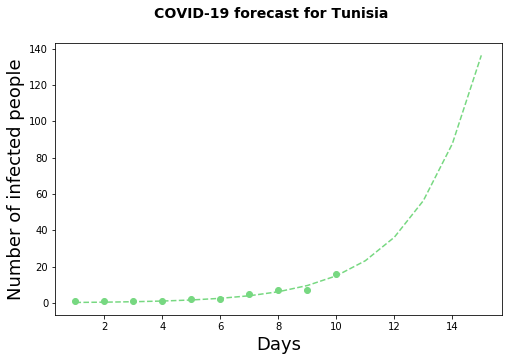

In [156]:
wrap(["Tunisia"], data)


In [240]:
Tunisia["days"]

0     1.0
1     2.0
2     3.0
3     4.0
4     5.0
5     6.0
6     7.0
7     8.0
8     9.0
9    10.0
Name: days, dtype: float64

In [229]:
Tunisia


,cumulative_count,date,days
0,1,2020-03-04,1.0
1,1,2020-03-05,2.0
2,1,2020-03-06,3.0
3,1,2020-03-07,4.0
4,2,2020-03-08,5.0
5,2,2020-03-09,6.0
6,5,2020-03-10,7.0
7,7,2020-03-11,8.0
8,7,2020-03-12,9.0
9,16,2020-03-13,10.0


In [114]:
np.linspace(1, 20, 20)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

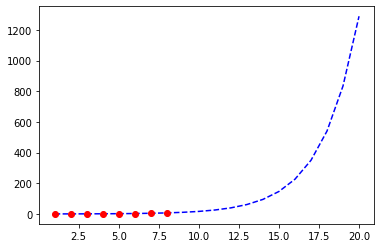

In [125]:
plt.plot(np.linspace(1, 20, 20), expgrowth(np.linspace(1, 20, 20), *popt),"--",color ="blue")

plt.plot(days, subpd[75],'o'  ,color ="red")
